This Week’s Extra Credit

As before, the probability that an M-seed defeats an N-seed is N/(M+N). But instead of 16 teams in a region, now suppose there are 2k teams, where k is a very large whole number.

The teams are seeded 1 through 2k, and play in a traditional seeded tournament format. That is, in the first round, the sum of opponents’ seeds is 2k+1. If the stronger team always advances, then the sum of opponents’ seeds in the second round is 2k−1+1, and so on. Of course, stronger teams may not always advance, but this convention tells you which seeds can play which other seeds in each round.

For any such region with 2k teams, what is the probability that the 1-seed emerges victorious from the region?

Plan is to create some code to calculate this probability and hope that it converges to something

In [25]:
from fractions import Fraction
def outcomes(k, level=0, min_seed=1):
    """This function takes k, level, and min_seed, which define where in the tree you are.
    On the downward part of the recursion, it fills out the tree, figuring out who will play against whom.
    On the upward part of the recursion, it calculates the probabilities of each outcome.
    Final result is all the teams along with their probability of emerging victorious"""

    if (level == k):
        # At the leaf of the tree, just return each team with probability 1.
        return {min_seed : 1}
    next_level = level + 1
    min_seed_sum = (2**next_level)+1
    Ao = outcomes(k, next_level, min_seed)
    Bo = outcomes(k, next_level, (min_seed_sum-min_seed))
    result = {}
    for a,pa in Ao.items():
        for b,pb in Bo.items():
            p_a_plays_b = pa * pb
            p_a_wins = (b/(a+b)) * p_a_plays_b
            p_b_wins = (a/(a+b)) * p_a_plays_b
            result[a] = p_a_wins + (result[a] if (a in result) else 0)
            result[b] = p_b_wins + (result[b] if (b in result) else 0)
    
    return result

Now lets try it out

In [26]:
outcomes(1)

{1: 0.6666666666666666, 2: 0.3333333333333333}

Makes sense.

In [27]:
outcomes(2)

{1: 0.56,
 2: 0.23999999999999996,
 3: 0.12571428571428572,
 4: 0.07428571428571429}

Matches hand-calculation.
So, let's proceed and plot the probability of the 1-seed emerging as k varies.

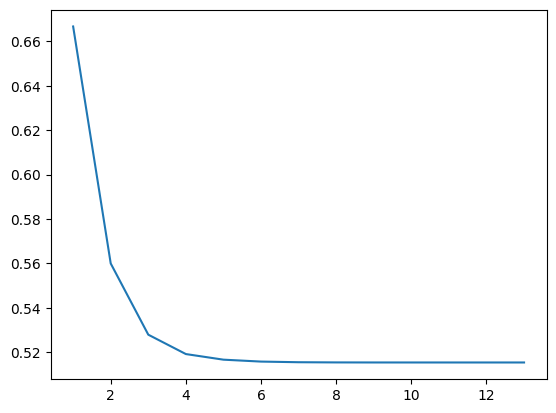

In [30]:
N=13
ks = range(1,N+1)
ps = [outcomes(k)[1] for k in ks]
import matplotlib.pyplot as plt
plt.plot(ks, ps)
plt.show()

In [31]:
for p in ps:
    print(p)

0.6666666666666666
0.56
0.5279401592158794
0.519218355130161
0.5166943992619706
0.515833745724985
0.5155445666341768
0.5154592300379058
0.515437219149804
0.5154322958839175
0.5154314095552367
0.5154313229728595
0.5154313454474814
